### Jade's Changes

<b>Current problems</b>:
- amp;
- div &gt; div.group &gt; p:first-child"&gt; = video cnbc
- no space between words separated by new line
- Check out the companies making headlines before the belldiv gt divgroup gt pfirstchildgt
- CNBC in general
- shit at the end: To contact... blah blah
- © CNBC is a USA TODAY content partner offering financial news and commentary. Its content is produced independently of USA TODAY.
- Read or Share this story:
- Read more here.
- FT subscribers can click here to receive Market Forces every day by email.
- Your feedback
- I'd love to hear from you. You can email me on michael.mackenzie@ft.com and follow me on Twitter at @michaellachlan.
- COPYRIGHT
- © 2019 Bloomberg L.P
- (Bloomberg)—
- Anything with "Transcript" should be removed
- Write to Sara Castellanos at sara.castellanos@wsj.com
- Disclosure: Cramer's charitable trust owns shares of Johnson &amp; Johnson.
- Questions for Cramer?Call Cramer: 1-800-743-CNBC
- Want to take a deep dive into Cramer's world? Hit him up!Mad Money Twitter - Jim Cramer Twitter - Facebook - Instagram
- Questions, comments, suggestions for the "Mad Money" website? madcap@cnbc.com
- RPT-

<b>Some rules I'm considering</b>:
- Rid articles with less than 5 periods
- Rid articles where writers say "I" a lot
- ~~Rid anything with Jim Cramer~~ done
- ~~Rid articles with title containing "transcript"~~ done
- ~~Rid articles with title containing "rpt" (repeat)~~ done

Within articles:
- Periods between 2 numbers should be preserved
- Remove any lines in articles that don't contain periods
- Remove any lines that don't have more than 5 words
- Remove sentences containing "more here"
- Remove anything after ©
- Remove any of the last 3 sentences if they contain "questions, comments" or "email" or "write to" or "I"

In [2]:
# imports
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import pandas as pd
import re, string

In [3]:
# Import articles
def importData(filename):
    """
    Import data into df
    """
    #Import Labelled Data
    DATA_DIR = "Data"
    thispath = Path().absolute()
    ARTICLES = os.path.join(DATA_DIR, filename)
    
    df = pd.read_excel(ARTICLES)

    try:
        df.head()
    except:
        pass
    return df

In [ ]:
from nltk.tokenize import sent_tokenize
def getSentences(paragraph):
    """
    Extracts sentences from a paragraph
    :param paragraph: (str) paragraph text
    :returns: list of sentences
    """
    indexed = {}
    sentenceList = tokenize.sent_tokenize(paragraph)
    for i, s in enumerate(sentenceList):
        indexed[i] = s
    return sentenceList, indexed

In [48]:
def DataClean(rawArticleDf):

    #remove blanks (NaN)
    cleanArticleDf = rawArticleDf.dropna(subset = ['content', 'title']) 

    #remove blocked articles without content
    cleanArticleDf = cleanArticleDf[cleanArticleDf.content.str.contains('Your usage has been flagged', case=False) == False]
    df = df[df.content.str.contains('To continue, please click the box', case=False) == False]
    
    # vidoes/ads/commentary
    df = df[df.description.str.contains('The "Fast Money" traders share their first moves for the market open.', case=False) == False]
    df = df[df.description.str.contains('stuff we think you', case=False) == False]
    
    #remove transcripts
    df = df[df.title.str.contains('transcript', case=False) == False]
    
    #remove cramer
    df = df[df.title.str.contains('cramer', case=False) == False]
    
    #remove duplicates
    # by self-identified repeat
    df = df[df.title.str.contains('rpt', case=False) == False]
    # by title
    df = df.drop_duplicates(subset=['title'], keep='first')
    # by content
    df = df.drop_duplicates(subset=['content'], keep='first')
    # by decription
    df = df.drop_duplicates(subset=['description'], keep='first')
    
    #remove punctuation, keep orig content
    df['origContent'] = df['content']
    pat_punctuation = re.compile('[^0-9a-zA-Z]+')
    content= map(lambda x: punctuation.sub(' ', x), df['content'])
    df['content']=list(content)
    
    #clean content, maintain punctuation
    df['origContent'] = df['cleanedContent']    
    #Replace new lines with spaces
    pat_newLine = re.compile('\s+')
    df['cleanedContent'] = list(map(lambda x: stripNewLine.sub(' ', x), df['cleanedContent']))
    
    #Remove any lines that don't have more than 5 words
    #Remove sentences containing "more here"
    #Remove anything after ©
    #Remove any of the last 3 sentences if they contain "questions, comments" or "email" or "write to" or "I"
    
        
    
    
    ## Commented out excel interaction ##
"""    
    OUTPUT_DIR = os.path.join(DATA_DIR, 'cleanedArticles.xlsx')
    writer = pd.ExcelWriter(OUTPUT_DIR)
    df.to_excel(writer,'Sheet1')
    writer.save()
"""
    return df

In [331]:
df = importData("newsApiOutput.xlsx")

In [332]:
#remove blanks (NaN)
df = df.dropna(subset = ['content', 'title']) 

#remove blocked articles without content
df = df[df.content.str.contains('Your usage has been flagged', case=False) == False]
df = df[df.content.str.contains('To continue, please click the box', case=False) == False]

# vidoes/ads/commentary
df = df[df.description.str.contains('The "Fast Money" traders share their first moves for the market open.', case=False) == False]
df = df[df.description.str.contains('stuff we think you', case=False) == False]

#remove transcripts
df = df[df.title.str.contains('transcript', case=False) == False]

#remove cramer
df = df[df.title.str.contains('cramer', case=False) == False]

#remove articles with less than words which is the lower end of the boxplot
df = df[df['content'].str.split().str.len() > 300]

#remove duplicates
# by self-identified repeat
df = df[df.title.str.contains('rpt', case=False) == False]
# by title
df = df.drop_duplicates(subset=['title'], keep='first')
# by content
df = df.drop_duplicates(subset=['content'], keep='first')
# by decription
df = df.drop_duplicates(subset=['description'], keep='first')


#clean content, maintain punctuation
df['origContent'] = df['content']  
# remove 
#Replace new lines with spaces
pat_amp = re.compile('amp;')
df['cleanContent'] = list(map(lambda x: pat_amp.sub('', x), df['content']))
#Replace new lines with spaces
pat_url = re.compile('[a-z]+?[.]?[a-z]+?[.]?[a-z]+[.]?[\/\/]\S+')
df['cleanContent'] = list(map(lambda x: pat_url.sub('URL', x), df['cleanContent']))
pat_https = re.compile('https://')
df['cleanContent'] = list(map(lambda x: pat_https.sub('', x), df['cleanContent']))

df = df.reset_index(drop=True)
for i in df.index:
    article = df['cleanContent'].iloc[i].split('\r\n')
    
    # remove lines with no period
    article[:] = [sentence for sentence in article if '.' in sentence]
    # remove lines with less than 5 words
    article[:] = [sentence for sentence in article if len(sentence.split())>5]
    
    # remove lines with terms that are associated with promotions or credits
    article[:] = [sentence for sentence in article if not('get breaking news' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('click here' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('write to' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('subscribe' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('read more' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('read or share' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('reporting by' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('twitter, instagram' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('Photo' in sentence)]
    article[:] = [sentence for sentence in article if not('copyright' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('©' in sentence.lower())]
    
    #print(article)
    df.at[i,'cleanContent']=' '.join(article)

pat_punctuation = re.compile('[^0-9a-zA-Z]+')
df['content'] = list(map(lambda x: pat_punctuation.sub(' ', x), df['cleanContent']))

In [339]:
df['cleanContent'].iloc[20]

'NEW YORK (Reuters) - Home furnishings retailer Crate and Barrel will partner with home services platform Handy to offer furniture assembly and home decor installation across the United States, joining a growing list of big box retailers seeking to win over shoppers with handyman services, a Handy spokesperson said on Monday.  Customers who dislike do-it-yourself chores will now be able to walk up to store associates at any of the 90 Crate and Barrel stores across the country and arrange for a Handy worker to come to their home between 7 a.m. and 11 p.m., any day of the week, to complete the task.  The Northbrook, Illinois-based retailer was expected to announce the partnership later on Monday. The decision is the latest example of a big box retailer responding to new online competition by offering a range of services complementing its furniture assortment.  Odd-jobs site Task Rabbit, a rival of Handy, was bought by Swedish furniture giant IKEA in September 2017. Determined to win over

In [284]:
df['content'].values

array(["Heisman Trophy winner Kyler Murray has made his decision: He’s choosing football over baseball.\r\nSomeone should tell team vice president Billy Beane.\r\nWith pitchers and catchers reporting to Oakland A’s camp on Monday, Beane understandably had to field questions about Murray. Beane said that no decision had been made by the Murray camp an hour before Murray announced his decision.\r\nBilly Beane wouldnt get too much into detail on Kyler Murray, only saying As continue to have private conversations with Murray and his team. Wouldnt comment on report of Murray attending combine, saying report didnt come from Murray or his representatives. URL\r\n— Martín Gallegos (@MartinJGallegos) February 11, 2019\r\nThat timing was … interesting.\r\nBeane said:\r\n“Things have certainly changed since the draft. A Heisman Trophy. He’s projected to be an early first-round pick … We’ve had ongoing conversations as it relates to the situation and as it relates to Kyler’s future, period. Not ju

In [265]:
df = df[df['content'].str.split().str.len() > 500]

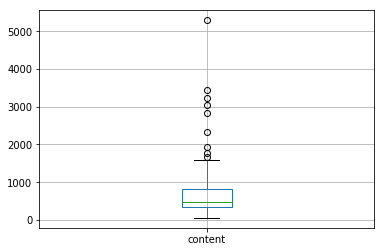

In [274]:
plot = df['content'].str.split().str.len().to_frame().boxplot()
plot

In [285]:
for i in df.index:
    article = df['content'].iloc[i].split('\r\n')
    
    # remove lines with no period
    article[:] = [sentence for sentence in article if '.' in sentence]
    # remove lines with less than 5 words
    article[:] = [sentence for sentence in article if len(sentence.split())>5]
    
    # remove lines with terms that are associated with promotions or credits
    article[:] = [sentence for sentence in article if not('click here' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('write to' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('subscribe' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('read more' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('read or share' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('Photo' in sentence)]
    article[:] = [sentence for sentence in article if not('copyright' in sentence.lower())]
    article[:] = [sentence for sentence in article if not('©' in sentence.lower())]
    
    #print(article)
    df.at[i,'content']=' '.join(article)

In [287]:
df['cleanedContent'].iloc[100]

'SAO PAULO (Reuters) - Brazilian environmental groups on Tuesday blasted President Jair Bolsonaro’s environment minister after he dismissed the murdered Amazon rain forest defender Chico Mendes as “irrelevant.”  “I don’t know Chico Mendes,” Environment Minister Ricardo Salles told journalists on an interview show late Monday night, when asked about the famous Brazilian rubber tapper, union leader and environmentalist who was murdered in 1988.  As environment minister, Salles oversees the Instituto Chico Mendes, which is named after the environmental advocate and oversees Brazil’s protected conservation areas.  Bolsonaro downplayed environmental concerns during his 2018 far-right presidential campaign, threatening to pull Brazil out of the Paris Agreement on climate change and advocating more mining and economic development in the Amazon rainforest.  Salles told interviewers on TV show Roda Viva that he hears contradictory accounts about Mendes’ life, saying environmentalists praise his

In [216]:
OUTPUT_DIR = os.path.join("Data", 'cleanedArticles_test.xlsx')
writer = pd.ExcelWriter(OUTPUT_DIR)
df.to_excel(writer,'Sheet1')
writer.save()